## Description
A generative adversarial network (GAN) is a class of machine learning system invented by Ian Goodfellow in 2014. Two neural networks compete with each other in a game. Given a training set, this technique learns to generate new data with the same statistics as the training set.

In this competition, we will be training generative models to create images of dogs. We will submit the images and be scored based on how well those images are classified as dogs from pre-trained neural networks.

### Data Characteristics
- **all-dogs.zip** - All dog images contained in the Stanford Dogs Dataset

- **Annotations.zip** - Class labels, Bounding boxes

In [3]:
# Basic
import numpy as np
from numpy import random
from numpy import vstack
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET

In [4]:
# Keras
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.models import load_model

## Load & prepare dataset

### Unzip data

In [5]:
import zipfile
import os

#　Path to the Zip file
annotation_dir = '/kaggle/input/generative-dog-images/Annotation.zip'
all_dogs_dir = '/kaggle/input/generative-dog-images/all-dogs.zip'

# Directory where you want to extract the files
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)

# Unzip files
with zipfile.ZipFile(annotation_dir, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

with zipfile.ZipFile(all_dogs_dir, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Unzipping complete! Files are extracted to {output_dir}")

Unzipping complete! Files are extracted to ../output


In [6]:
%%capture
import glob
import os

image = glob.glob(os.path.join(output_dir, '**', '*.jpg'), recursive=True)
print("Found JPG files:")
for jpg_file in image:
    print(jpg_file)

In [7]:
breed = glob.glob('../output/Annotation/*')
annot = glob.glob('../output/Annotation/*/*')
print(len(image), len(breed), len(annot))

20579 120 20580


In [8]:
def get_bbox(annot):
    """
    This extracts and returns values of bounding boxes
    """
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [9]:
def get_image(annot):
    """
    Retrieve the corresponding image given annotation file
    """
    img_path = '../output/all-dogs/'
    file = annot.split('/')
    img_filename = img_path+file[-1]+'.jpg'
    return img_filename

In [10]:
# Initialize tensor for dog images
n_x = 64
n_c = 3
dogs = np.zeros((len(image), n_x, n_x, n_c))
print(dogs.shape)

(20579, 64, 64, 3)


In [11]:
for a in range(len(image)):
    bbox = get_bbox(annot[a])
    dog = get_image(annot[a])
    if dog == '../output/all-dogs/n02105855_2933.jpg':   # this jpg is not in the dataset
        continue
    im = Image.open(dog)
    im = im.crop(bbox[0])
    im = im.resize((64,64), Image.Resampling.LANCZOS)
    dogs[a,:,:,:] = np.asarray(im) / 255.

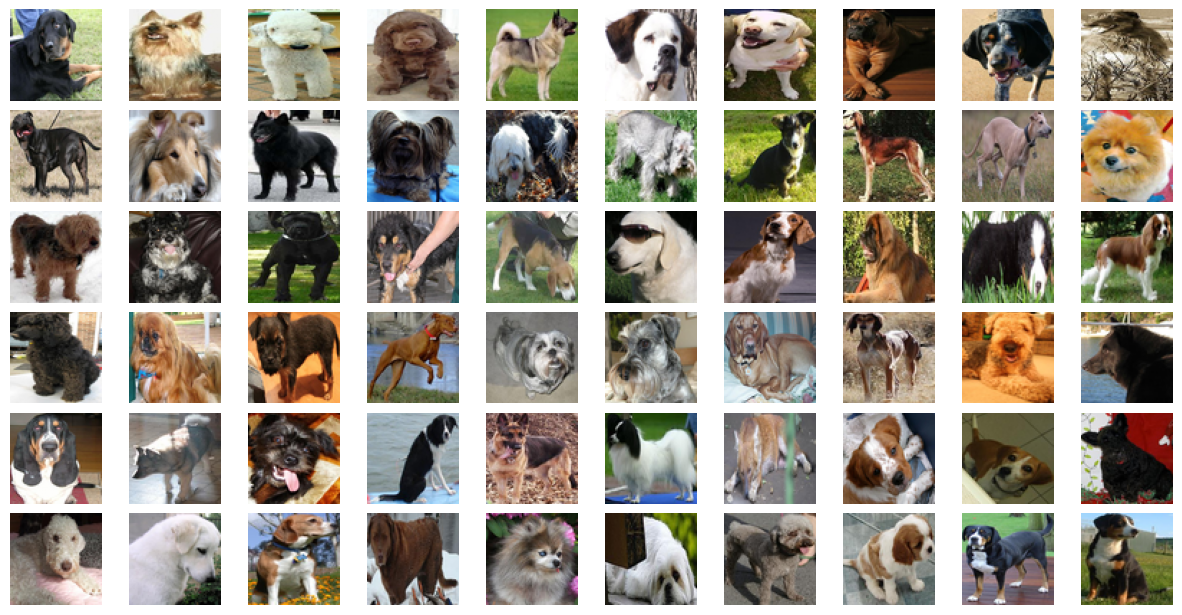

In [12]:
# Pick some images randomly from dogs and look at these
plt.figure(figsize=(15,8))
n_images = 60
select = random.randint(low=0,high=dogs.shape[0],size=n_images)
for i, index in enumerate(select):  
    plt.subplot(6, 10, i+1)
    plt.imshow(dogs[index])
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [14]:
# Scale from [0,1] to [-1,1]
dogs = (dogs*2)-1

## The Discriminator

The discriminator takes a sample "image" from our dataset and says whether it is real or fake.

**Inputs**: "image" 64x64 pixels in size; three channels (RGB).

**Outputs**: binary classification, likelihood the sample is real.

In [15]:
def define_discriminator(in_shape=(n_x,n_x,n_c)):
    """
    Define the conv net for the discriminator
    """
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    model.add(Conv2D(64,kernel_size=3,padding='same',
                     input_shape=in_shape,kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,kernel_size=4,strides=2,padding='same',
                     kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,kernel_size=4,strides=2,padding='same',
                     kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256,kernel_size=4,strides=2,padding='same',
                     kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dropout(rate=0.4))
    model.add(Dense(1,activation='sigmoid'))
    
    # Compile
    opt = Adam(learning_rate=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

In [16]:
discriminator = define_discriminator()
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 936,193 (3.57 MB)

 Trainable params: 936,193 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

### Training of the Discriminator

All image samples will be labelled '1' (real). Need to create fake samples labelled as '0'. The fake samples will be created by the Generator. The real and fake samples will be fed into the Discriminator by batches.

In [17]:
def generate_real_samples(data, n_samples):
    """
    Pick 'n_samples' randomly from 'data'
    """
    idx = random.randint(low=0,high=data.shape[0],size=n_samples)
    X = data[idx]
    Y = np.ones((n_samples,1))
    return X, Y

## The Generator
The Generator creates new, fake but plausible images. It works by taking a point from a latent space as input and output an image.

**Inputs**: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.

**Outputs**: 2D color image (3 channels; RGB) of 64x64 pixels with pixel values in [-1,1].

In [18]:
def define_generator(latent_dim):
    """
    Define the conv net for the generator
    """
    init = RandomNormal(stddev=0.02)
    n_nodes = 128*8*8
    model = Sequential()
    model.add(Dense(n_nodes,input_dim=latent_dim,kernel_initializer=init)) # foundation for 8*8 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8,8,128)))
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',
                              kernel_initializer=init)) # up-sample to 16*16 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',
                              kernel_initializer=init)) # up-sample to 32*32 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',
                              kernel_initializer=init)) # up-sample to 64*64 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3,kernel_size=3,activation='tanh',padding='same',
                     kernel_initializer=init))
    return model

In [19]:
# Define size of latent space
latent_dim = 200
generator = define_generator(latent_dim)

generator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,646,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,436,867 (9.30 MB)

 Trainable params: 2,436,867 (9.30 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def generate_latent_points(latent_dim, n_samples):
    """
    This generates points in the latent space as input for the generator
    """
    x_input = random.randn(latent_dim * n_samples)    # Sample from normal/gaussian distribution (best practice)
    x_input = x_input.reshape(n_samples, latent_dim)     # Reshape into a batch of inputs for the network
    return x_input

In [21]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    """
    Generate 'n_samples' of fake samples from the generator
    """
    X_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(X_input)    # Generator predicts output
    Y = np.zeros((n_samples,1))     # Create class labels '0' for fake sample
    return X, Y

## Combining the Discriminator & Generator as a GAN

In [22]:
def define_gan(g_model, d_model):
    """
    This takes as arguments the generator and discriminator and creates the GAN subsuming these two models. 
    The weights in the discriminator are marked as not trainable, 
    which only affects the weights as seen by the GAN and not the standalone discriminator model.
    """
    d_model.trainable = False     # Make weights in the discriminator not trainable
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [23]:
gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │     2,436,867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │       936,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,373,060 (12.87 MB)

 Trainable params: 2,436,867 (9.30 MB)

 Non-trainable params: 936,193 (3.57 MB)

## Functions to evaluate performance of GAN

In [24]:
def save_plot(examples, epoch, n=10):
    """
    This creates and save a plot of generated images
    """
    examples = (examples+1)/2.0
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i])
    plt.title('Epoch %03d' % (epoch+1))
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [25]:
# Evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, data, latent_dim, n_samples=100):
    """
    This evaluates the discriminator, plot generated images, save generator model
    """
    X_real, Y_real = generate_real_samples(data, n_samples)
    _, acc_real = d_model.evaluate(X_real, Y_real, verbose=0)   # evaluate discriminator on real samples
    X_fake, Y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(X_fake, Y_fake, verbose=0)   # evaluate discriminator on fake samples
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))    # summarize discriminator performance
    save_plot(X_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [28]:
def train(g_model, d_model, gan_model, data, latent_dim, n_epochs=10, batch_size=32):
    """
    This trains the combined generator and discriminator models in the GAN
    """
    batch_per_epoch = data.shape[0] // batch_size
    half_batch = batch_size // 2
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, Y_real = generate_real_samples(data, half_batch)   # randomly select real samples
            d_loss1, _ = d_model.train_on_batch(X_real, Y_real)   # update discriminator model weights
            X_fake, Y_fake = generate_fake_samples(g_model, latent_dim, half_batch)   # generate fake samples
            d_loss2, _ = d_model.train_on_batch(X_fake, Y_fake)   # update discriminator model weights
            X_gan = generate_latent_points(latent_dim, batch_size)   # as input for generator
            Y_gan = np.ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(X_gan, Y_gan)   # update generator via the discriminator's error
            #print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss)) # summarize loss for batch
        # evaluate the model performance, sometimes
        if (i+1) % 25 == 0: 
            summarize_performance(i, g_model, d_model, data, latent_dim)

In [ ]:
%%capture

latent_dim = 200
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
data = dogs
train(g_model, d_model, gan_model, data, latent_dim)

In [ ]:
image = Image.open('generated_plot_e300.png')
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(image)

## Using the Generator model to generate new dog images

The generation of each image requires a point in the latent space as input.

In [27]:
def show_plot(examples, n):
    """
    This shows the plots from the GAN
    """
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i,:,:])
    plt.subplots_adjust(wspace=0.3, hspace=-0.1)
    plt.show()

In [ ]:
latent_points = generate_latent_points(200, 10000)
new_images = g_model.predict(latent_points)
new_images = (new_images+1)/2.0
show_plot(new_images, 8)

In [ ]:
new_images.shape

In [ ]:
test = Image.fromarray((255*new_images[8383]).astype('uint8').reshape((64,64,3)))
plt.imshow(test)

## Create zip file to store the images

In [ ]:
z = zipfile.PyZipFile('images.zip', mode='w')
for d in range(10000):
    dog_image = Image.fromarray((255*new_images[d]).astype('uint8').reshape((64,64,3)))
    f = str(d)+'.png'
    dog_image.save(f,'PNG')
    z.write(f)
    os.remove(f)
z.close()

## Conclusion

GAN has successfully learned to generate dog images. This would demonstrate that the model has reached an equilibrium where the generator produces convincing fake images, and the discriminator struggles to distinguish between real and fake data.

GAN training was very expensive in terms of computational resources and many times errors occurred because the memory limit was reached. So I downsized the number of Epochs and Batch to reduce memory consumption and computational complexity in training.

Depending on the results, future work could focus on improving image quality (e.g., through techniques like Progressive GANs or StyleGAN), increasing training stability, or using a more diverse dog dataset to expand the model's generalization ability.